In [183]:
# Import libraries

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns


# Pretty display for notebooks

%matplotlib inline


# Allows the use of display() for DataFrames
from IPython.display import display 

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
train = pd.read_csv("../asset/train.csv")
test = pd.read_csv("../asset/test.csv")
weather = pd.read_csv("../asset/weather.csv")
key = pd.read_csv("../asset/key.csv")
submission_example = pd.read_csv("../asset/sampleSubmission.csv")

# Success - Display the first record
print("Train data : ", train.shape)
print("Test  data : ", test.shape)
print("weather  data : ", weather.shape)
print("key  data : ", key.shape)
print("submission  data : ", submission_example.shape)

coulmns_should_be_integer_type_of_data = ["tmax", "tmin", "tavg", "dewpoint", "wetbulb", "heat", "cool"]
coulmns_should_be_float_type_of_data = ["snowfall", "preciptotal", "stnpressure", "sealevel", "depart",\
                                        "resultspeed", "resultdir", "avgspeed"]
# 원본을 유지하기 위해서 카피
df_train = train.copy()
df_weather = weather.copy()
df_key = key.copy()
import costum_functions as cf

import pickle

with open('slackUrl.pickle', 'rb') as f:
    slack_url = pickle.load(f)

Train data :  (4617600, 4)
Test  data :  (526917, 3)
weather  data :  (20517, 20)
key  data :  (45, 2)
submission  data :  (526917, 2)


In [5]:
df_key.tail()

,store_nbr,station_nbr
40,41,12
41,42,14
42,43,11
43,44,12
44,45,16


In [6]:
df_key_reset = df_key.set_index("store_nbr")

In [7]:
store_nbr_li = [d[0] for d in df_key_reset.get_values()]

In [8]:
df_train.loc[0]["store_nbr"]

1

In [9]:
def addStationNbrColumnToDataFrame(df):
    li = []
    for i in range(len(df)):
        index = df.loc[i]["store_nbr"]
        li.append(store_nbr_li[index - 1])
    df_train["station_nbr"] = li

In [10]:
cf.saveDataFrameToCsv(df_train, "df_train_with_station_nbr")

## Weather data

- Column : 전문용어
    - station_nbr : 기성청 번호
    - date : 날짜
- Temp : 화씨(Fahrenheit)
    - tmax : 최고 온도
    - tmin : 최저 온도
    - tavg : 평균 온도
    - depart : Departure from normal
    - dewpoint : 평균 이슬점
    - wetbulb : 평균 습구?
- Degree Days : Base 65 F
    - Heat : Heating (Season begins with July)
    - Cool : Cooling (Season begins with January)
    - sunrise : Sunrise (Calculated, not observed)
    - sunset : Sunset (Calculated, not observed)
- Significant Weather Types : 날씨 현상
    - codesum : 날씨현상, NO SIGN은 보통인 날을 의미한다.
- Snow/Ice : 인치
    - snowfall : 1/10인치, M = Missing Data, T = Trace
    - preciptotal : 비나, 녹은 눈 인치, M = Missing Data, T = Trace
- Pressure : 인치당 핵토그램(HG)?
    - stnpressure : AVERAGE STATION PRESSURE
    - sealevel : AVERAGE SEA LEVEL PRESSURE
- Wind : SPEED IN MILES PER HOUR, DIRECTION TO TENS OF DEGREES
    - resultspeed : Resultant Wind Speed
    - resultdir : Resultant Wind Direction
    - avgspeed : Average Speed
    
##### _**℃＝(℉－32)/1.8**_

In [12]:
df = df_train.copy()
df['log1p'] = np.log(df['units'] + 1)

g = df.groupby(["store_nbr", "item_nbr"])['log1p'].mean()

In [13]:
# date 포맷을 2014-01-01 object타입에서 20140101 타입으로 전환
df_weather["date"] = df_weather["date"].apply(cf.dateToNumeric)
df_train["date"] = df_train["date"].apply(cf.dateToNumeric)

# Weather 데이터 컬럼별 Missing Data 수량

In [14]:
cf.isThereNoneData(df_weather)

,Column,Missing Data,Trace Data
0,station_nbr,0,0
1,date,0,0
2,tmax,906,0
3,tmin,908,0
4,tavg,1469,0
5,depart,11511,0
6,dewpoint,666,0
7,wetbulb,1252,0
8,heat,1469,0
9,cool,1469,0


In [15]:
df_weather.groupby(by="station_nbr").size()

station_nbr
1     1035
2     1035
3     1035
4     1035
5      852
6     1035
7     1035
8     1035
9     1035
10    1035
11    1035
12    1035
13    1035
14    1035
15    1035
16    1035
17    1035
18    1035
19    1035
20    1035
dtype: int64

In [16]:
numerical_features, categorical_features = cf.divideIntoNumericAndCategoricalVariables(df_weather)

Numerical Features Qty : 2 

Numerical Features :  ['station_nbr', 'date'] 


Categorical Features Qty : 18 

Categorical Features : ['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed']


In [17]:
df_weather.tail()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
20512,16,20141031,53,34,44,M,35,41,21,0,-,-,,M,0.00,29.90,29.99,4.5,03,5.3
20513,17,20141031,59,34,47,M,32,41,18,0,-,-,RA,0.0,0.00,29.72,30.39,9.2,01,9.3
20514,18,20141031,67,49,58,-4,40,50,7,0,0644,1738,,0.0,0.00,29.78,30.28,10.6,36,11.2
20515,19,20141031,45,33,39,-6,24,32,26,0,0624,1646,RA SN,0.1,0.02,29.51,30.24,20.4,34,20.9
20516,20,20141031,68,50,59,M,39,50,6,0,-,-,,0.0,0.00,29.57,30.27,10.5,36,11.2


In [18]:
check_depart = df_weather[df_weather["depart"] != "M"]

In [19]:
check_depart["depart"].astype(int).describe()

count    9006.000000
mean        1.363091
std         7.646759
min       -35.000000
25%        -3.000000
50%         2.000000
75%         6.000000
max        33.000000
Name: depart, dtype: float64

- 총 2012-01-01 부터 2014-10-31까지 1035일간의 자료이지만 5번 기상청의 경우에는 852일간의 기록밖에 없다.

In [20]:
df_key = df_key.sort_values(by = ['station_nbr']).reset_index(drop=True)
df_key = df_key.reindex_axis(["station_nbr", "store_nbr"], axis = 1)

In [21]:
df_classifyStoresByStation = cf.classifyStoresByStation(df_key)

In [22]:
df_classifyStoresByStation

,station_nbr,store_nbr
0,1,1
1,2,16
2,3,"29, 21, 33"
3,4,8
4,5,35
5,6,"13, 7"
6,7,"3, 28, 20"
7,8,39
8,9,"24, 4"
9,10,"11, 27, 22"


In [23]:
# store_nbr 31, 26, 18, 9, 34, 23 by station_nbr == 17 
df_test = cf.df_train_specified_store(df_train, df_classifyStoresByStation, 17)

In [24]:
df_test.tail()

,date,store_nbr,item_nbr,units
630697,20141031,23,107,0
630698,20141031,23,108,0
630699,20141031,23,109,0
630700,20141031,23,110,0
630701,20141031,23,111,0


In [25]:
def drawDateAndItemUnitsImg(df, item_nbr):
    df = df.set_index("date")
    unique_store_nbr = df["store_nbr"].unique()
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(top = 5)
    for i, store_nbr in enumerate(list(unique_store_nbr)):
        if(i == 1):
            item = df[df["item_nbr"] == item_nbr]
            item = item[item["store_nbr"] == store_nbr]
#             print(item["units"].describe())
            plt.subplot(len(list(unique_store_nbr)), 1, i + 1)
#             sns.barplot(item.index, item["units"])
#             plt.tick_params(
#                 axis='x',          # changes apply to the x-axis
#                 which='both',      # both major and minor ticks are affected
#                 bottom=False,      # ticks along the bottom edge are off
#                 top=False,         # ticks along the top edge are off
#                 labelbottom=False) 
#             plt.xticks()
            plt.plot(item.index, item["units"])
            plt.ylabel("store_nbr {}".format(store_nbr))
    plt.show()

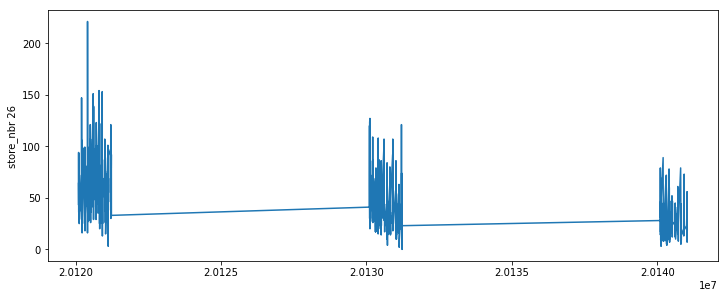

In [26]:
drawDateAndItemUnitsImg(df_test, 5)

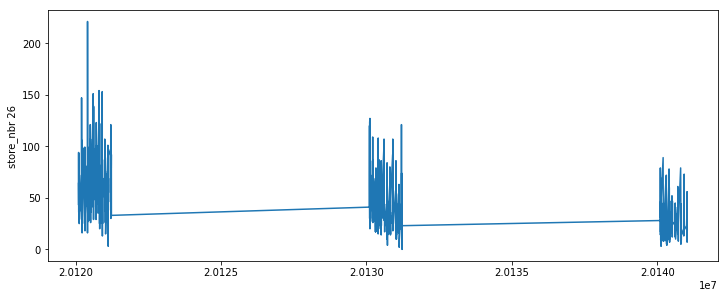

In [27]:
drawDateAndItemUnitsImg(df_test, 5)

In [84]:
cf.sendSlackDm(slack_url,"test")

In [85]:
df_merging = pd.read_csv("df_train_with_station_nbr201806202007 (1).csv")

In [86]:
df_merging["date"] = df_merging["date"].apply(cf.dateToNumeric)

In [87]:
df_merging.tail()

,date,store_nbr,item_nbr,units,station_nbr
4617595,20141031,45,107,0,16
4617596,20141031,45,108,0,16
4617597,20141031,45,109,0,16
4617598,20141031,45,110,0,16
4617599,20141031,45,111,0,16


In [92]:
df_weather["date"] = df_weather["date"].apply(cf.dateToNumeric)

In [95]:
df_weather.tail()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
20512,16,20141031,53,34,44,M,35,41,21,0,-,-,,M,0.00,29.90,29.99,4.5,03,5.3
20513,17,20141031,59,34,47,M,32,41,18,0,-,-,RA,0.0,0.00,29.72,30.39,9.2,01,9.3
20514,18,20141031,67,49,58,-4,40,50,7,0,0644,1738,,0.0,0.00,29.78,30.28,10.6,36,11.2
20515,19,20141031,45,33,39,-6,24,32,26,0,0624,1646,RA SN,0.1,0.02,29.51,30.24,20.4,34,20.9
20516,20,20141031,68,50,59,M,39,50,6,0,-,-,,0.0,0.00,29.57,30.27,10.5,36,11.2


In [96]:
df_total = pd.merge(df_merging, df_weather, left_on = ['date', 'station_nbr'], right_on=['date', 'station_nbr'])

In [97]:
df_total.tail()

,date,store_nbr,item_nbr,units,station_nbr,tmax,tmin,tavg,depart,dewpoint,...,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
4617595,20141031,39,107,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617596,20141031,39,108,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617597,20141031,39,109,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617598,20141031,39,110,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617599,20141031,39,111,2,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1


In [98]:
df_total1 = pd.merge(df_merging, df_weather, on=['date', 'station_nbr'])

In [100]:
df_total1.tail()

,date,store_nbr,item_nbr,units,station_nbr,tmax,tmin,tavg,depart,dewpoint,...,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
4617595,20141031,39,107,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617596,20141031,39,108,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617597,20141031,39,109,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617598,20141031,39,110,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617599,20141031,39,111,2,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1


In [127]:
df_sumunits = pd.DataFrame(columns = ["date","item_nbr", "units"])

In [69]:
# 피벗 만들기, 인덱스 - 컬럼 - 해당값
df_wpivot = df_weather.pivot("date", "station_nbr", "tmax")

In [74]:
df_wpivot.head()

station_nbr,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
date,,,,,,,,,,,,,,,,,,,,
2012-01-01,52,48,55,63,NaN,63,50,66,34,73,72,72,38,50,48,50,56,59,38,59
2012-01-02,50,46,45,60,NaN,60,44,59,21,65,63,65,50,45,43,50,45,53,25,53
2012-01-03,32,28,55,62,NaN,62,60,61,28,48,44,47,55,60,30,32,55,59,26,59
2012-01-04,28,21,63,73,NaN,71,58,72,39,53,54,53,58,58,23,27,63,62,34,62
2012-01-05,38,31,68,70,NaN,71,66,70,46,68,68,68,66,67,36,38,68,66,47,67


In [79]:
df_wpivot.columns

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20],
           dtype='int64', name='station_nbr')

In [132]:
df_total1.tail()

,date,store_nbr,item_nbr,units,station_nbr,tmax,tmin,tavg,depart,dewpoint,...,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
4617595,20141031,39,107,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617596,20141031,39,108,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617597,20141031,39,109,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617598,20141031,39,110,0,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1
4617599,20141031,39,111,2,8,78,55,67,M,M,...,-,-,RA,M,T,29.82,M,M,M,5.1


In [139]:
df_total[df_total["station_nbr"]==5].tail() #데이터 필터링

,date,store_nbr,item_nbr,units,station_nbr,tmax,tmin,tavg,depart,dewpoint,...,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
4617373,20141031,35,107,0,5,M,M,M,M,37,...,0616,1640,,M,M,M,30.01,10.8,05,M
4617374,20141031,35,108,0,5,M,M,M,M,37,...,0616,1640,,M,M,M,30.01,10.8,05,M
4617375,20141031,35,109,0,5,M,M,M,M,37,...,0616,1640,,M,M,M,30.01,10.8,05,M
4617376,20141031,35,110,0,5,M,M,M,M,37,...,0616,1640,,M,M,M,30.01,10.8,05,M
4617377,20141031,35,111,0,5,M,M,M,M,37,...,0616,1640,,M,M,M,30.01,10.8,05,M


In [140]:
df_weather.tail()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
20512,16,20141031,53,34,44,M,35,41,21,0,-,-,,M,0.00,29.90,29.99,4.5,03,5.3
20513,17,20141031,59,34,47,M,32,41,18,0,-,-,RA,0.0,0.00,29.72,30.39,9.2,01,9.3
20514,18,20141031,67,49,58,-4,40,50,7,0,0644,1738,,0.0,0.00,29.78,30.28,10.6,36,11.2
20515,19,20141031,45,33,39,-6,24,32,26,0,0624,1646,RA SN,0.1,0.02,29.51,30.24,20.4,34,20.9
20516,20,20141031,68,50,59,M,39,50,6,0,-,-,,0.0,0.00,29.57,30.27,10.5,36,11.2


In [184]:
#스테이션 별로 데이터프레임 나누기
weather_list = []
for i in range(1,21):
    weather_list.append(df_weather[df_weather["station_nbr"]==i])

In [185]:
weather_list[0].tail()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
20417,1,2014-10-27,61,41,51,M,38,44,14,0,-,-,,M,0.00,29.70,29.89,6.3,27,7.3
20437,1,2014-10-28,65,37,51,M,45,48,14,0,-,-,BR,M,0.00,29.86,30.02,1.4,09,3.6
20457,1,2014-10-29,66,48,57,M,51,53,8,0,-,-,RA FG+ FG BR,M,0.11,29.70,29.86,2.9,27,4.4
20477,1,2014-10-30,57,39,48,M,39,43,17,0,-,-,,M,0.00,29.78,29.95,2.1,28,3.7
20497,1,2014-10-31,53,40,47,M,36,41,18,0,-,-,,M,0.00,29.87,30.03,5.4,04,5.8


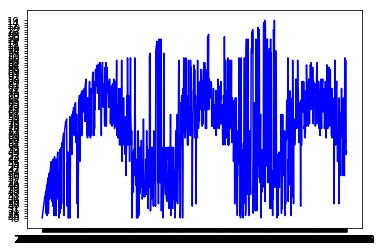

In [186]:
plt.figure(figsize=(4, 3))
plt.plot(weather_list[1]["date"], weather_list[1]["tmax"], color='blue')
plt.show()